# <center>Desafio Cientista de Dados Lighthouse 2024</center>

In [2]:
import pandas as pd

df = pd.read_csv("teste_indicium_precificacao.csv")
df.head()

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150              3                  0           NaN   
2  Entire home/apt     89              1                270    2019-07-05   
3  Entire home/apt     80             10                  9    2018-11-19   
4  Entire home/apt    200              3                 74    2019-06-22   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  
0             0.38                              2                  355  
1              NaN                              1                  365  
2             4.64                              1                  194  
3             0.10                              1                    0  
4             0.59                              1                  129

# 1. Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses de negócio relacionadas. Seja criativo!

In [3]:
colunas_numericas = ["price", "minimo_noites", "numero_de_reviews", "reviews_por_mes", "calculado_host_listings_count", "disponibilidade_365"]
dados_numericos = df[colunas_numericas]
dados_numericos.describe()

price  minimo_noites  numero_de_reviews  reviews_por_mes  \
count  48894.000000   48894.000000       48894.000000     38842.000000   
mean     152.720763       7.030085          23.274758         1.373251   
std      240.156625      20.510741          44.550991         1.680453   
min        0.000000       1.000000           0.000000         0.010000   
25%       69.000000       1.000000           1.000000         0.190000   
50%      106.000000       3.000000           5.000000         0.720000   
75%      175.000000       5.000000          24.000000         2.020000   
max    10000.000000    1250.000000         629.000000        58.500000   

       calculado_host_listings_count  disponibilidade_365  
count                   48894.000000         48894.000000  
mean                        7.144005           112.776169  
std                        32.952855           131.618692  
min                         1.000000             0.000000  
25%                         1.000000             0.000000  
50%                         1.000000            45.000000  
75%                         2.000000           227.000000  
max                       327.000000           365.000000

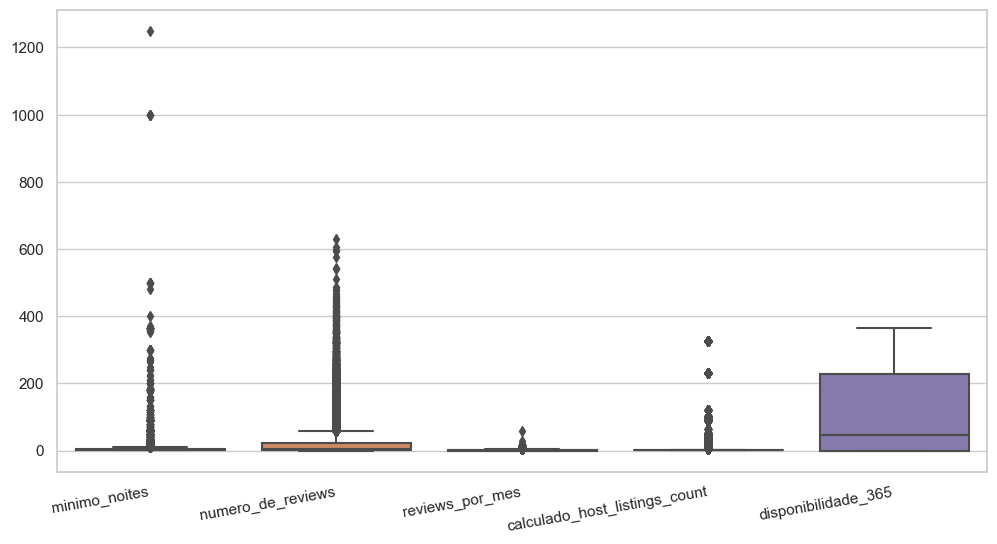

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.switch_backend('module://ipykernel.pylab.backend_inline')

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6)) 
sns.boxplot(df[colunas_numericas].drop(colunas_numericas[0], axis=1))
plt.xticks(rotation=10, ha='right')
plt.show()

- A variável "número calculado de listagens do host" indica que a maioria dos hosts tem um número baixo de listagens, mas há hosts com um número significativo de listagens, sendo provavelmente empresas que utilizam a plataforma para divulgar seus imóveis para aluguel.
- A variável "mínimo de noites" tem uma média relativamente baixa, mas um desvio padrão alto, indicando uma grande variação nos requisitos mínimos de noites. É possível analisar pelo gráfico box-plot a presença de outliers explícitos, que pedem contratos de no mínimo 2 anos.

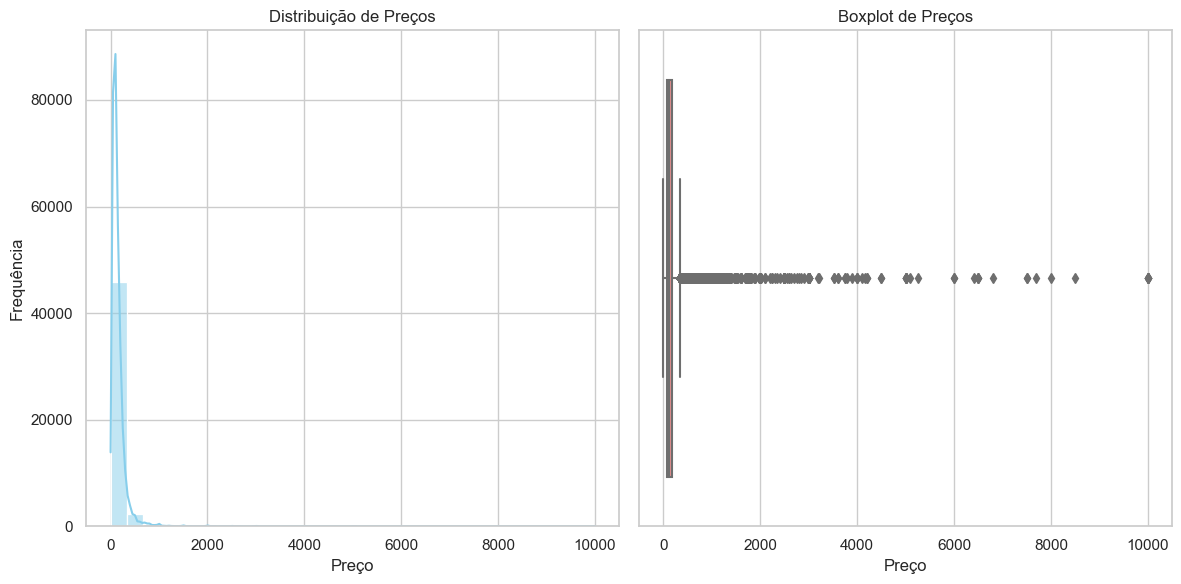

In [35]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

#Histograma
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição de Preços')
plt.xlabel('Preço')
plt.ylabel('Frequência')

#Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'], color='lightcoral')
plt.title('Boxplot de Preços')
plt.xlabel('Preço')

plt.tight_layout()
plt.show()


In [39]:
import numpy as np
percentis = [90, 95, 99]
for percentil in percentis:
    valor_percentil = np.percentile(df['price'], percentil)
    print(f'{percentil}º Percentil: {valor_percentil}')


90º Percentil: 269.0
95º Percentil: 355.0
99º Percentil: 799.0


- A variável preço possui uma grande variação, com valores indo de $0 até $10,000. Essa média está sendo afetada por causa dos valores extremamente altos. Isso indica a presença de muitos outliers, mostrando a importância do tratamento dessa variável antes da criação do modelo preditivo, já que o preço é o target. Além disso, 90% dos apartamentos listados custam, por noite, 269 dolares ou menos, sugerindo que a maioria das propriedades tem preços relativamente baixos. O histograma demonstra isso muito bem com sua curva assimétrica.

In [100]:
import folium
from folium.plugins import HeatMap
import geopandas as gpd

#Pontos turisticos
landmarks = {
    'Central Park': (40.7851, -73.9683),
    'Times Square': (40.7589, -73.9851),
    'Estátua da Liberdade': (40.6892, -74.0445),
}

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

#Definição do sistema de cordenadas
gdf.crs = "EPSG:4326"

#Converter os dados de latitude e longitude para coordenadas latitudinais e longitudinais
gdf['latitude'] = gdf.geometry.y
gdf['longitude'] = gdf.geometry.x

grid = gdf.geometry.simplify(0.01).envelope
grid_gdf = gpd.GeoDataFrame(geometry=grid)

#Média dos preços em cada célula
grid_gdf['price_mean'] = gdf.sjoin(grid_gdf).groupby('index_right')['price'].mean()

#Converter coordenadas para strings
grid_gdf['latitude_str'] = grid_gdf['geometry'].centroid.y.astype(str)
grid_gdf['longitude_str'] = grid_gdf['geometry'].centroid.x.astype(str)

#Mapa inicia centrado em Nova York
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

#Choropleth para delinear os bairros
folium.Choropleth(
    geo_data="https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson",
    fill_opacity=0,
    line_opacity=0.7,
    line_color='black',
    line_weight=2,
).add_to(nyc_map)

#Heatmap dos preços
HeatMap(data=grid_gdf[['latitude_str', 'longitude_str', 'price_mean']], radius=15).add_to(nyc_map)

for landmark, coords in landmarks.items():
    folium.Marker(location=coords, popup=landmark, icon=folium.Icon(color='red')).add_to(nyc_map)

#Bairros
folium.Marker([40.78, -73.97], popup="Manhattan", icon=None, tooltip="Manhattan").add_to(nyc_map)
folium.Marker([40.63, -73.95], popup="Brooklyn", icon=None, tooltip="Brooklyn").add_to(nyc_map)
folium.Marker([40.84, -73.88], popup="Bronx", icon=None, tooltip="Bronx").add_to(nyc_map)
folium.Marker([40.75, -73.8], popup="Queens", icon=None, tooltip="Queens").add_to(nyc_map)
folium.Marker([40.55, -74.15], popup="Staten Island", icon=None, tooltip="Staten Island").add_to(nyc_map)

nyc_map


C:\Users\thiag\AppData\Local\Temp\ipykernel_4716\3762161654.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['latitude_str'] = grid_gdf['geometry'].centroid.y.astype(str)
C:\Users\thiag\AppData\Local\Temp\ipykernel_4716\3762161654.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['longitude_str'] = grid_gdf['geometry'].centroid.x.astype(str)


- Ao analisar as localidades com a maior incidência de vermelho no heatmap, indicando que são as mais caras, é possível ver que a maioria se localiza entre o Central Park e a Estátua da Liberdade. Também é possível ver que apenas alguns pontos específicos em Staten Island possuem casas listadas.

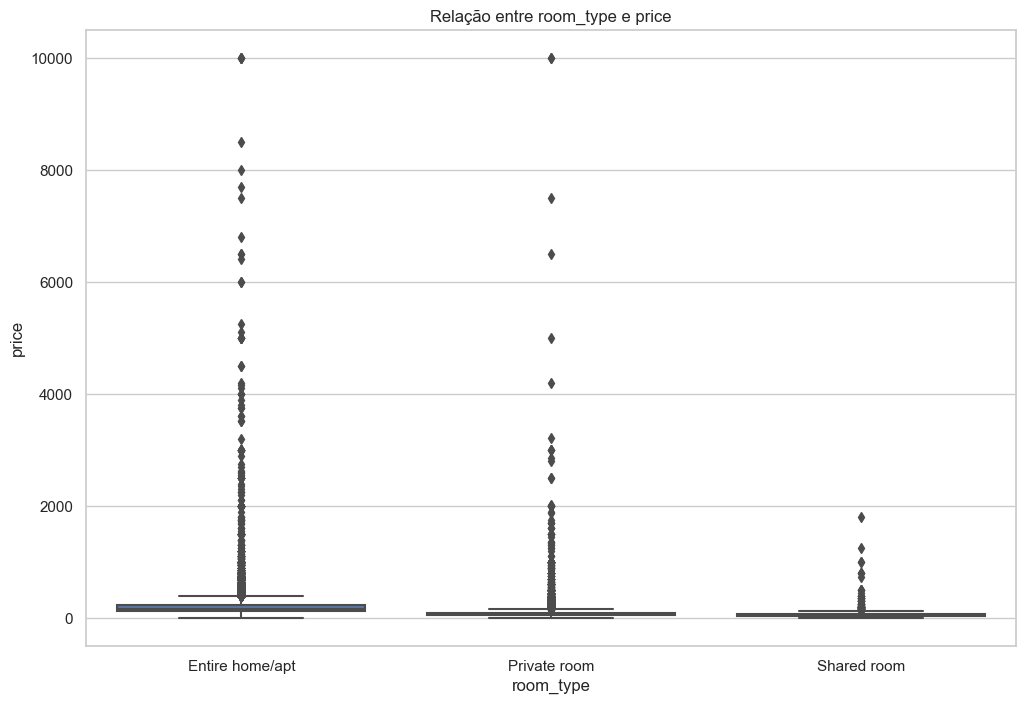

In [74]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Relação entre room_type e price')
plt.show()


### Há uma diferença significativa de preços entre propriedades de diferentes tipos?
- Quarto Completo/Apto tem a média de preço mais alta, seguido por Quarto Privado e Quarto Compartilhado.
- Quarto Compartilhado tem a tendência de ser mais barato.
- Para todas as categorias, há propriedades listadas com preço mínimo de $0.00, o que pode indicar dados incongruentes ou propriedades gratuitas.

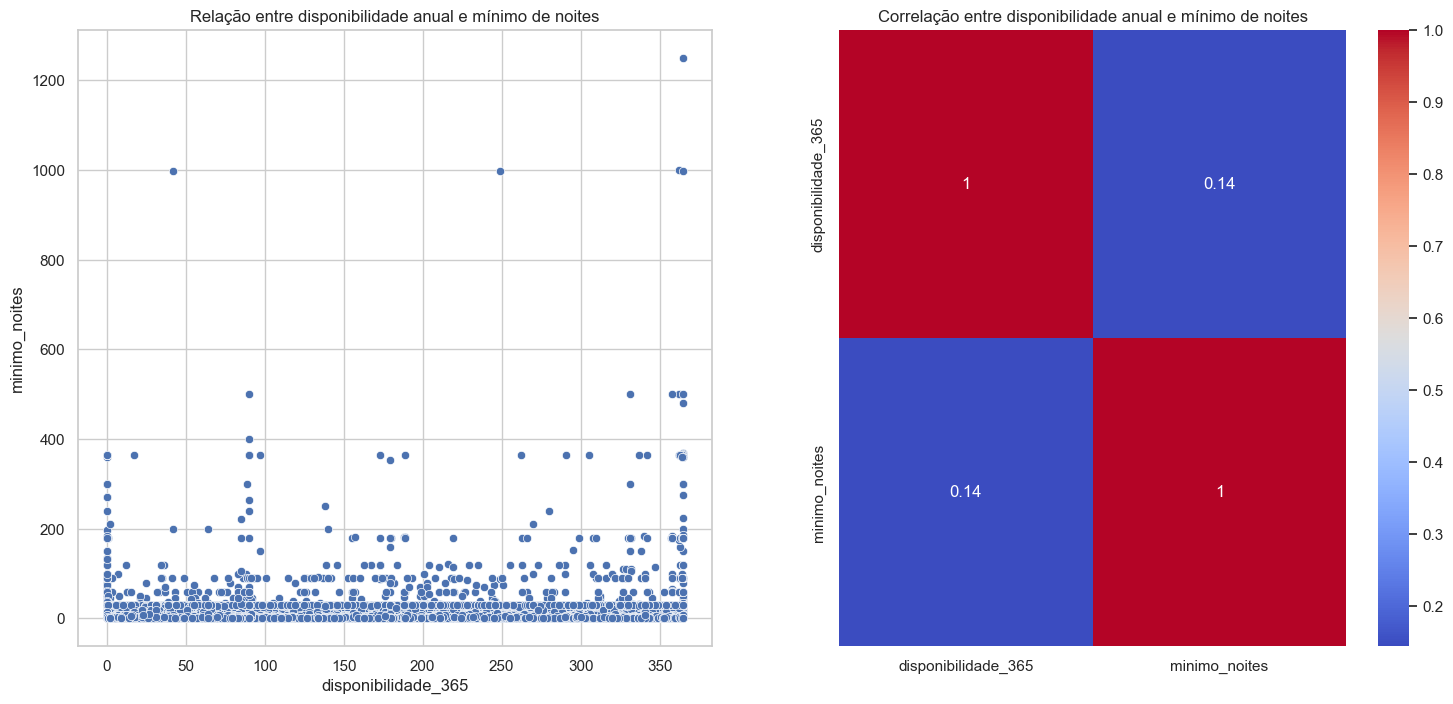

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

sns.scatterplot(x='disponibilidade_365', y='minimo_noites', data=df, ax=axes[0])
axes[0].set_title('Relação entre disponibilidade anual e mínimo de noites')

correlation_matrix = df[['disponibilidade_365', 'minimo_noites']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlação entre disponibilidade anual e mínimo de noites')

plt.show()



- A correlação de aproximadamente 0,14 entre "disponibilidade_365" e "minimo_noites" indica uma relação positiva leve. No entanto, ao analisar o gráfico de dispersão, não se evidencia uma forte relação linear entre as variáveis. Isso sugere que, embora haja uma associação positiva leve, a disponibilidade anual de um imóvel não está fortemente vinculada ao número mínimo de noites necessárias para uma reserva. Ou seja, a diminuição da disponibilidade no ano não parece ser um preditor direto da exigência de um maior número de noites para reserva.

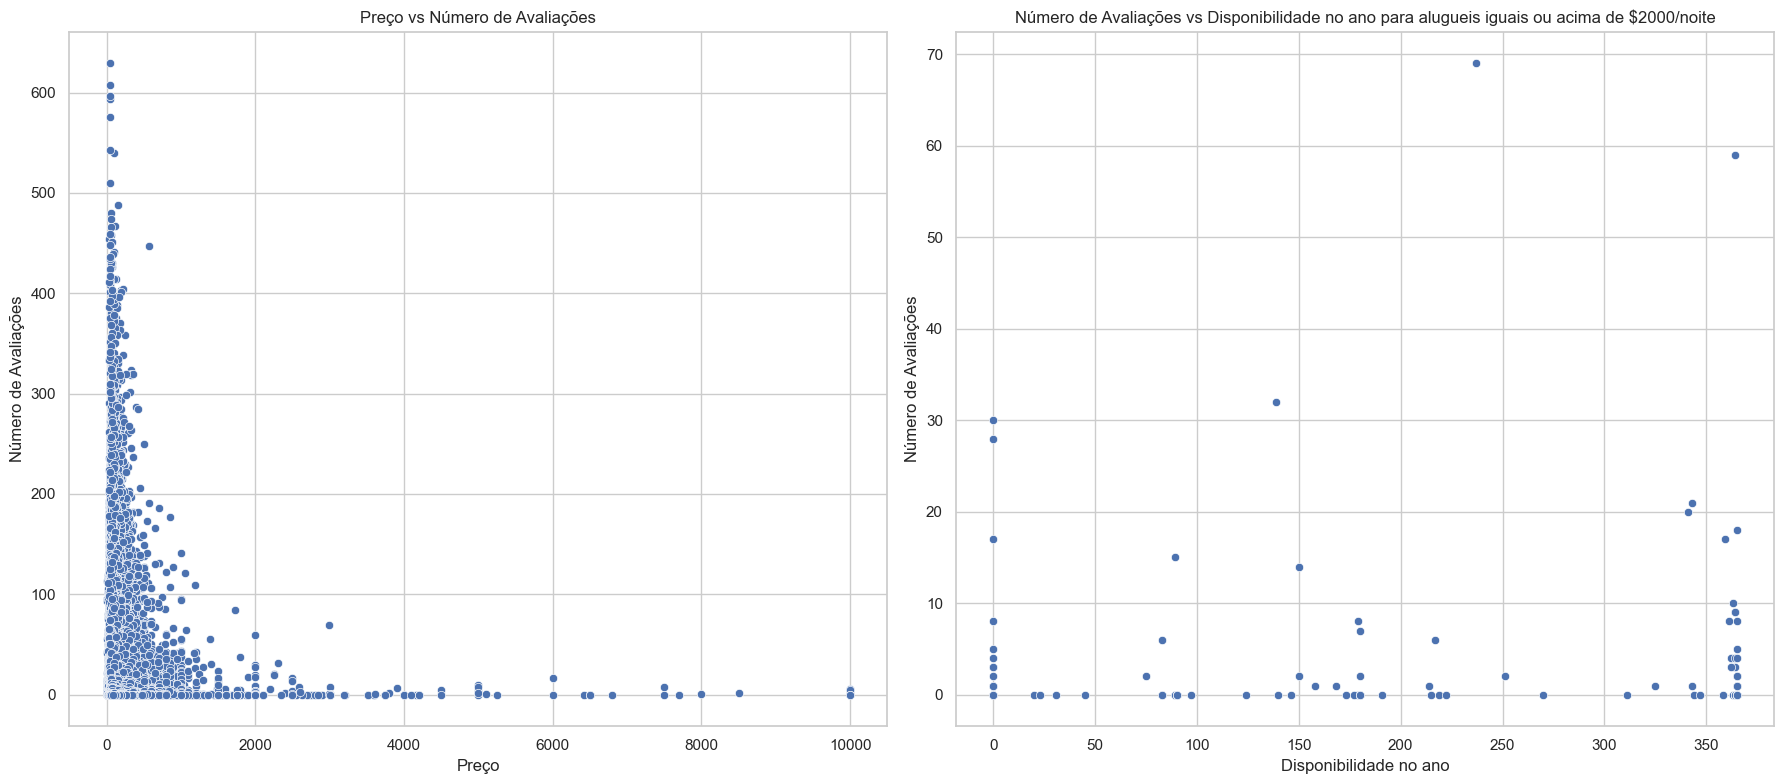

In [92]:
df_high_price = df[df['price'] >= 2000]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.scatterplot(ax=axes[0], x='price', y='numero_de_reviews', data=df)
axes[0].set_title('Preço vs Número de Avaliações')
axes[0].set_xlabel('Preço')
axes[0].set_ylabel('Número de Avaliações')

sns.scatterplot(ax=axes[1], x='disponibilidade_365', y='numero_de_reviews', data=df_high_price)
axes[1].set_title('Número de Avaliações vs Disponibilidade no ano para alugueis iguais ou acima de $2000/noite')
axes[1].set_xlabel('Disponibilidade no ano')
axes[1].set_ylabel('Número de Avaliações')

plt.tight_layout()
plt.show()




### Propriedades com uma quantidade mínima de avaliações têm preços mais altos?

- A quantidade de avaliações não aparenta interferir no preço listado dos anuncios, no qual as listagens mais populares são as mais em conta. 
- O número de avaliações para listagens mais caras são muito menores, mas há muitos alugueis mais em conta que também possuem pouca ou nenhuma avaliação.
- O número de avaliações em alugueis acima de 2000 dolares/noite constata que não é o número de avaliações que garante a ocupação.

-------------------------------------------------

# 2.a. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

O melhor lugar para uma pessoa comprar um apartamento para alugar é aquele que custa o mais barato possível e pode ser alugado mais caro que a média

Criar uma nova coluna com a % entre: (média de valores de aluguel/média de valores de compra) para cada bairro

In [3]:
df.groupby("bairro_group")["price"].mean()

bairro_group
Bronx             87.496792
Brooklyn         124.381983
Manhattan        196.875814
Queens            99.517649
Staten Island    114.812332
Name: price, dtype: float64

In [5]:
df['ultima_review'] = pd.to_datetime(df['ultima_review'])
df['ultima_review'].describe()

count                            38842
mean     2018-10-04 01:46:50.710055936
min                2011-03-28 00:00:00
25%                2018-07-08 00:00:00
50%                2019-05-19 00:00:00
75%                2019-06-23 00:00:00
max                2019-07-08 00:00:00
Name: ultima_review, dtype: object

Utilizando os dados do Street Easy (https://streeteasy.com/blog/data-dashboard/) será possível obter o valor médio pedido por square foot de cada bairro. Será utilizado o valor médio da última review (Outubro de 2018) para adquirir esses valores, tendo em vista que essa tabela não é recente.

In [6]:
df_ppsf = pd.DataFrame(df.groupby("bairro_group")["price"].mean())
df_ppsf["PPSF"] = [309, 699, 1525, 533, 359]
df_ppsf["ratio"] = df_ppsf["price"]/df_ppsf["PPSF"]
df_ppsf

price  PPSF     ratio
bairro_group                             
Bronx           87.496792   309  0.283161
Brooklyn       124.381983   699  0.177943
Manhattan      196.875814  1525  0.129099
Queens          99.517649   533  0.186712
Staten Island  114.812332   359  0.319812

Quanto maior o ratio, melhor para o locador (dono do imóvel alugado). Nesse caso, o melhor local para comprar um imóvel para alugar seria em Staten Island

In [7]:
df.groupby("bairro_group")["disponibilidade_365"].mean()

bairro_group
Bronx            165.758937
Brooklyn         100.219122
Manhattan        111.979410
Queens           144.451818
Staten Island    199.678284
Name: disponibilidade_365, dtype: float64

Porém, nada adianta ter um ratio alto e o imóvel não alugar (alta taxa de vacância). Dessa forma, Brooklyn apresenta a menor média.

Ao combinar as duas informações, Bronx apresenta o meio termo, tendo imóveis mais baratos e com uma taxa de vacância apenas 15% acima da média. 
## Assim, o local de compra mais indicado é no **Bronx**.

-------------------------------------------------

### 2.b. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

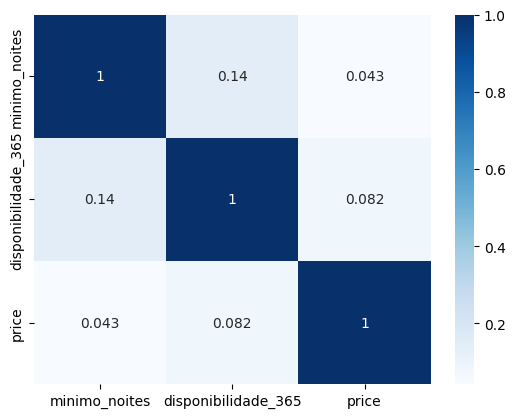

In [8]:
sns.heatmap(df[["minimo_noites", "disponibilidade_365", "price"]].corr(), annot=True, cmap="Blues")
plt.show()

## Como o índice de correlação demonstra, o número mínimo de noites e a disponibilidade ao longo do ano **não interferem** de forma significativa no preço.

-------------------------------------------------

### 2.c. Existe algum padrão no texto do nome do local para lugares de mais alto valor?

In [9]:
df['price'].describe()

count    48894.000000
mean       152.720763
std        240.156625
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Para definir os locais de maior valor, será utilizado como treshold os imóveis 25% mais caros da lista, tendo seu valor como 175 ou superior.

In [10]:
df_alto_valor = df[df['price'] >= 175]
df_alto_valor = df_alto_valor[["nome", "price"]]
df_alto_valor

nome  price
0                                  Skylit Midtown Castle    225
4              Large Cozy 1 BR Apartment In Midtown East    200
15                     Perfect for Your Parents + Garden    215
18                     Huge 2 BR Upper East  Cental Park    190
19                      Sweet and Spacious Brooklyn Loft    299
...                                                  ...    ...
48852     Sunny&quiet paradise in the WV with open views    202
48855  Large 3 bed, 2 bath , garden , bbq , all you need    345
48871                                      Nycity-MyHome    260
48883        Brooklyn Oasis in the heart of Williamsburg    190
48885                    Comfy 1 Bedroom in Midtown East    200

[12940 rows x 2 columns]

In [11]:
import re

nomes = df['nome'].str.lower().str.cat(sep=' ')
nomes_tratados = re.sub(r'[^a-z\s]', '', nomes) #Remove caracteres especiais
palavras = nomes_tratados.split()

pd.Series(palavras).value_counts().head(20)

in           16756
room         10101
bedroom       8043
private       7176
apartment     6708
cozy          5006
apt           4634
brooklyn      4057
studio        4000
the           3906
to            3827
br            3823
spacious      3729
manhattan     3460
with          3103
park          3050
east          3019
of            2999
sunny         2884
and           2871
Name: count, dtype: int64

##### É necessário remover as palavras mais utilizadas que não geram valor à analise, as chamadas stopwords.

In [12]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

palavras_token = word_tokenize(nomes_tratados)
stop_words = set(stopwords.words('english'))
palavras_filtradas = [word for word in palavras_token if word not in stop_words]

pd.Series(palavras_filtradas).value_counts().head(20)

room            10101
bedroom          8043
private          7176
apartment        6708
cozy             5006
apt              4634
brooklyn         4057
studio           4000
br               3823
spacious         3729
manhattan        3460
park             3050
east             3019
sunny            2884
williamsburg     2639
beautiful        2479
near             2319
village          2260
nyc              2179
heart            2051
Name: count, dtype: int64

## Algumas palavras aparecem com frequência na listagem de imóveis com maior valor, sendo elas:

- Tipo do alojamento: se é um quarto, sala, apartamento.
- Localização: Brooklyn, Manhattan, Williamsburg, East, NYC.
- Características: Cozy, spacious, sunny, beautiful.
- Proximidade de lugares importantes: Near, heart (centro, coração da cidade).

## Sendo assim, **existe** um padrão no texto do nome do local para lugares de mais alto valor.

-------------------------------------------------

# 3. Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


## Devido a característica contínua da variável preço, estamos resolvendo um problema de **regressão**.
## Colunas a serem removidas:
- bairro: por ter valores categóricos distintos, é necessário ser convertido com o Label Encoder, o que pode introduzir uma ordem artificial que o modelo pode interpretar erroneamente. Isso acontece pois, ao atribuir valores ordinais aleatórios para os bairros, os de maior valor atribuido podem ter o maior peso para o modelo. Para corrigir isso, pode ser utilizado o OneHotEncoding, que criaria diversas colunas. Porém, já que existem muitos valores distintos para os bairros, isso aumentaria a dimensionalidade dos dados. Para isso, as colunas bairro_group, latitude e longitude já devem ser suficientes para que o modelo entenda a localização dos imóveis.
- ultima_review, revies_por_mes: possui 20% dos seus valores como nulo. Colocar o valor da média para preencher os nulos pode causar bias.
- host_name: os modelos de regressão não se dão muito bem com object, e 23,4% desses nomes são distintos. Creio que deixar essa coluna levaria o modelo ao overfitting.
- host_id e id: o indíce normalmente não é relevante, e a coluna calculado_host_listings_count já mostra se o dono do imóvel possui outros imóveis listados.
- nome: 98% distinct e do tipo object, não ajudaria em nada o modelo.
## Colunas a serem tratadas:
- bairro_group, room_type: será utilizado o label encoding para transformar a variável categorica em inteiros.
- price: devido a sua característica de possuir grande variância, será feita a transformação logarítmica para normalizar a distribuição dos dados

## Medida de performance escolhida (métrica):
A métrica escolhida foi o **RMSE (Root Mean Squared Error)**, que penaliza de maneira significativa os erros maiores, permitindo que o modelo tenha a tendência de minimizar os erros para uma ampla gama de valores. Assim, será possível escolher o modelo que irá prever os valores mais exatos, se comparado com outros modelos.

In [14]:
df_model = df.drop(["bairro", "ultima_review", "host_name", "host_id", "id", "nome", "reviews_por_mes"], axis=1)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for coluna in ["bairro_group", "room_type"]:
    df_model[coluna] = label_encoder.fit_transform(df[coluna])
    print(f"Valores trocados no Label Encoder na coluna {coluna}:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

df_model

Valores trocados no Label Encoder na coluna bairro_group: {'Bronx': 0, 'Brooklyn': 1, 'Manhattan': 2, 'Queens': 3, 'Staten Island': 4}
Valores trocados no Label Encoder na coluna room_type: {'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}


bairro_group  latitude  longitude  room_type  price  minimo_noites  \
0                 2  40.75362  -73.98377          0    225              1   
1                 2  40.80902  -73.94190          1    150              3   
2                 1  40.68514  -73.95976          0     89              1   
3                 2  40.79851  -73.94399          0     80             10   
4                 2  40.74767  -73.97500          0    200              3   
...             ...       ...        ...        ...    ...            ...   
48889             1  40.67853  -73.94995          1     70              2   
48890             1  40.70184  -73.93317          1     40              4   
48891             2  40.81475  -73.94867          0    115             10   
48892             2  40.75751  -73.99112          2     55              1   
48893             2  40.76404  -73.98933          1     90              7   

       numero_de_reviews  calculado_host_listings_count  disponibilidade_365  
0                     45                              2                  355  
1                      0                              1                  365  
2                    270                              1                  194  
3                      9                              1                    0  
4                     74                              1                  129  
...                  ...                            ...                  ...  
48889                  0                              2                    9  
48890                  0                              2                   36  
48891                  0                              1                   27  
48892                  0                              6                    2  
48893                  0                              1                   23  

[48894 rows x 9 columns]

In [16]:
from sklearn.model_selection import train_test_split

test_size = 0.30
random_state = 42


y = np.log1p(df_model["price"]) #Transformação logarítmica
x = df_model.drop("price", axis=1)

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=test_size, random_state=random_state)

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#MODELO DE REGRESSÃO LINEAR
modelo_regressaolinear = LinearRegression()
modelo_regressaolinear.fit(x_treino, y_treino)
previsao_regressaolinear = modelo_regressaolinear.predict(x_teste)
rmse_regressaolinear = mean_squared_error(y_teste, previsao_regressaolinear, squared=False)
print("Regressão linear:", "Root Mean Squared Error (RMSE):", rmse_regressaolinear)

#MODELO DE ÁRVORE DE DECISÃO
modelo_arvoredecisao = RandomForestRegressor()
modelo_arvoredecisao.fit(x_treino, y_treino)
previsao_arvoredecisao = modelo_arvoredecisao.predict(x_teste)
rmse_ad = mean_squared_error(y_teste, previsao_arvoredecisao, squared=False)
print("Arvore de decisão:", "Root Mean Squared Error (RMSE):", rmse_ad)

Regressão linear: Root Mean Squared Error (RMSE): 0.5051127935426888


Arvore de decisão: Root Mean Squared Error (RMSE): 0.4389070261264372


In [42]:
#MODELO DE REDES NEURAIS

modelo_mlp = make_pipeline(StandardScaler(), MLPRegressor(max_iter=5000)) #Cria uma pipeline que normaliza os dados utilizando o StandardScaler para posteriormente ser utilizado no modelo de redes neurais

#Utilizando o GridSearchCV, é possível testar diferentes parametros paraa o modelo, a fim de identificar o mais adequado e com o menor RMSE.
parametros_grid = {
    'mlpregressor__hidden_layer_sizes': [(100, 50, 10), (50, 25, 5), (75, 25)],
    'mlpregressor__activation': ['relu', 'tanh', 'identity', 'logistic'],
    'mlpregressor__solver': ['adam', 'lbfgs'],
    'mlpregressor__alpha': [0.001, 0.01],
}

grid_search_mlp = GridSearchCV(estimator=modelo_mlp, param_grid=parametros_grid, 
                               scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search_mlp.fit(x_treino, y_treino)
print("Melhores Parâmetros para MLPRegressor:", grid_search_mlp.best_params_)
print("Melhor Score (neg_mean_squared_error):", grid_search_mlp.best_score_)
previsao_mlp_grid = grid_search_mlp.best_estimator_.predict(x_teste)
rmse_mlp_grid = mean_squared_error(y_teste, previsao_mlp_grid, squared=False)
print("MLPRegressor (GridSearch):", "Root Mean Squared Error (RMSE):", rmse_mlp_grid)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


Melhores Parâmetros para MLPRegressor: {'mlpregressor__activation': 'tanh', 'mlpregressor__alpha': 0.001, 'mlpregressor__hidden_layer_sizes': (50, 25, 5), 'mlpregressor__solver': 'adam'}
Melhor Score (neg_mean_squared_error): -0.21304255493289825
MLPRegressor (GridSearch): Root Mean Squared Error (RMSE): 0.44505496385905585


In [24]:
#MODELO XGBOOST
modelo_xgboost = XGBRegressor()

parametros_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

grid_search_xgboost = GridSearchCV(estimator=modelo_xgboost, param_grid=parametros_grid, 
                                   scoring='neg_mean_squared_error', cv=3)
grid_search_xgboost.fit(x_treino, y_treino)
print("Melhores Parâmetros para XGBoost:", grid_search_xgboost.best_params_)
previsao_xgboost = grid_search_xgboost.best_estimator_.predict(x_teste)
rmse_xgboost = mean_squared_error(y_teste, previsao_xgboost, squared=False)
print("XGBoost:", "Root Mean Squared Error (RMSE):", rmse_xgboost)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END 

In [37]:
#MODELO LGBM
modelo_lightgbm = LGBMRegressor()

parametros_grid = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 7, 10],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'num_leaves': [30, 40, 50, 60],
    'min_child_samples': [10, 15, 20],
}
grid_search_lightgbm = GridSearchCV(estimator=modelo_lightgbm, param_grid=parametros_grid, 
                                    scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search_lightgbm.fit(x_treino, y_treino)
print("Melhores Parâmetros para LightGBM:", grid_search_lightgbm.best_params_)
previsao_lightgbm = grid_search_lightgbm.best_estimator_.predict(x_teste)
rmse_lightgbm = mean_squared_error(y_teste, previsao_lightgbm, squared=False)
print("LightGBM:", "Root Mean Squared Error (RMSE):", rmse_lightgbm)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1121
[LightGBM] [Info] Number of data points in the train set: 34225, number of used features: 8
[LightGBM] [Info] Start training from score 4.738184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## O menor valor de RMSE indica o melhor aproveitamento do modelo em relação a essa métrica. Assim, o modelo que melhor se aproxima dos dados é o **LightGBM**.
## Prós do LGBM:
- Velocidade de aprendizado dos dados.
- Possibilidade de modificar parametros, a fim de ajustar o modelo aos dados.
- Possui a característica de gradient boosting, corrigindo os erros e melhorando o modelo durante seu treinamento, tornando-o mais robusto.

## Contras do LGBM:
- Requer mais memória, devido a sua estrutura baseada em árvore.
- Cria folhas mais complexas e mais profundas que outros modelos baseado em árvore, tornando sua interpretabilidade mais difícil.

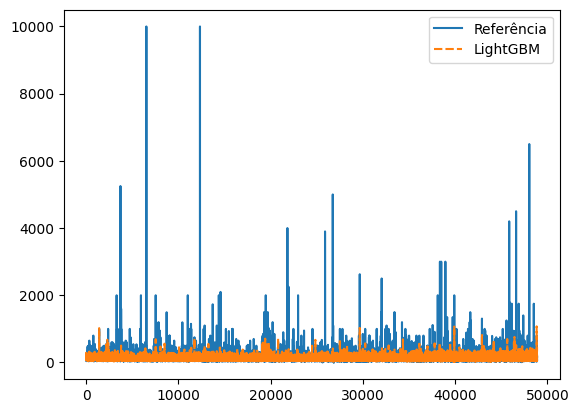

In [43]:
df_predict = pd.DataFrame()
df_predict["Referência"] = np.expm1(y_teste)
df_predict["LightGBM"] = np.expm1(previsao_lightgbm)
    

sns.lineplot(data=df_predict)
plt.show()


---------------

# 4. Supondo um apartamento com as seguintes características, qual seria a sua sugestão de preço?
![Características do apartamento](4questao.png)



In [44]:
df_model.columns

Index(['bairro_group', 'latitude', 'longitude', 'room_type', 'price',
       'minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count',
       'disponibilidade_365'],
      dtype='object')

In [52]:
ap_prev = [[2, 40.75362, -73.98377, 0, 1, 45, 2, 355]] #input dos dados fornecidos
price_pred = grid_search_lightgbm.best_estimator_.predict(ap_prev)
print("O preço sugerido para esse apartamento é:", np.expm1(price_pred[0]))

O preço sugerido para esse apartamento é: 314.17513431875614


## A minha sugestão de preço, baseado no modelo criado, é de **314** dólares.

----------------

# 5. Salve o modelo desenvolvido no formato .pkl. 


In [51]:
import pickle

with open('modelo_lgbm_previsao.pkl', 'wb') as file:
    pickle.dump(grid_search_lightgbm, file)